In [1]:
#default_exp vision.learner.adversary

In [2]:
%config Completer.use_jedi = False

# Adversarial Learner

This requires *pytorch >= 1.3.1* due to a bug with fp16 argmax in lesser versions

Note: Overhead is ~3x vanilla training (1x generate adversarial batch, 1x predict adversarial batch, 1x predict clean batch)

The idea comes from this paper: https://arxiv.org/abs/1911.09665v1, and here we implement a variant of AdvProp with a dynamic attack strength
using the Projected Gradient Descent attack and a moving epsilon


In [3]:
#export
import copy as cp
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastcore.all import *
from fastai2.callback.all import *
from fastai2.metrics import accuracy
from fastai2.learner import *

# PGD modified from https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3
def projected_gradient_descent(model, x, y, loss_fn, num_steps=1, step_size=1, step_norm='inf', eps=0.4, eps_norm='inf',
                               clamp=None, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    targeted = y_target is not None
    num_channels = x.shape[1]
    
    # We need to generate adversarial examples with adversarial batch norm
    model.set_bn_mode_aux()

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach()
        
        # apparently .requires_grad_(True) doesn't work??
        _x_adv.requires_grad = True

        prediction = model(_x_adv)
        loss = loss_fn(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # Note .view() assumes batched image data as 4D tensor
                gradients = _x_adv.grad * step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
                    .norm(step_norm, dim=-1)\
                    .view(-1, num_channels, 1, 1)

            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], -1).norm(norm, dim=1)
            scaling_factor[mask] = eps

            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, 1, 1, 1)

            x_adv = x + delta
            
        # Only clamp if we request it
        if clamp is not None:
            x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()

In [4]:
#export
class Attack():
    ''' Basic attacker interface. '''
    def __init__(self, *args, **kwargs):
        pass
    
    def __call__(self, model, x, y, loss, **kwargs):
        raise NotImplementedError

In [5]:
#export
class PGDAttack(Attack):
    def __init__(self, num_steps=1, step_size=1, step_norm='inf', eps=0.4, eps_norm='inf', clamp=(0, 1), y_target=None):
        super(PGDAttack, self).__init__()
        self.num_steps = num_steps
        self.step_size = step_size
        self.step_norm = step_norm
        self.eps = eps
        self.eps_norm = eps_norm
        self.clamp = clamp
        self.y_target = y_target
        
    def __call__(self, model, x, y, loss, *args, **kwargs):
        return projected_gradient_descent(
            model,
            x,
            y,
            loss,
            num_steps=self.num_steps,
            step_size=self.step_size,
            eps=self.eps,
            eps_norm=self.eps_norm,
            clamp=self.clamp,
            y_target=self.y_target
        )

We need to patch `nn.Module` to have a flag for clean vs adversarial training

In [6]:
#export
@patch
def set_bn_mode_clean(self:nn.Module):
    self.training_mode = 0
    for child in self.children():
        child.set_bn_mode_clean()
    
@patch
def set_bn_mode_aux(self:nn.Module):
    self.training_mode = 1
    for child in self.children():
        child.set_bn_mode_aux()

We need to create a batchnorm layer which is toggleable between clean/aux modes

TODO: Need to implement an inverse operation to \_inject_aux_bns when exporting a model... we don't want to export this, but only the clean batch norms

In [7]:
#export
class AuxBatchNorm(nn.Module):
    def __init__(self, clean_bn, aux_bn):
        super(AuxBatchNorm, self).__init__()
        # Training modes: {clean: 0, aux: 1}
        self.training_mode = 0
        self.clean_bn = clean_bn
        self.aux_bn = aux_bn
    
    def forward(self, x):
        # Auxiliary is _only_ used when training against adv. examples, otherwise we use 
        # the clean batch norm.
        if self.training and self.training_mode == 1:
            return self.aux_bn(x)
        return self.clean_bn(x)

In [8]:
#export
def _inject_aux_bns(model, debug=False):
    '''Replaces all batch norm layers in a pytorch model with an clean/auxiliary one'''
    if debug:
        print('Initial Model:', model)
    def _inject(module):
        # Recursively update the model
        for child in module.children():
            # Don't inject aux batchnorms
            if isinstance(child, AuxBatchNorm):
                if debug: print('Skipping Existing AuxBatchNorm')
                return
            _inject(child)
            
        # Do the replacement
        for name, child in module.named_children():
            # Note, we want to copy.deepcopy as we want to preserve the weights from pretraining, etc.
            if isinstance(child, nn.BatchNorm1d):
                if debug: print('Updating BatchNorm1d', name)
                setattr(module, name, AuxBatchNorm(cp.deepcopy(child), cp.deepcopy(child)))
            if isinstance(child, nn.BatchNorm2d):
                if debug: print('Updating BatchNorm2d', name)
                setattr(module, name, AuxBatchNorm(cp.deepcopy(child), cp.deepcopy(child)))
            if isinstance(child, nn.BatchNorm3d):
                if debug: print('Updating BatchNorm3d', name)
                setattr(module, name, AuxBatchNorm(cp.deepcopy(child), cp.deepcopy(child)))
    
    _inject(model)
    
    if debug:
        print('Injected Model:', model)

In [9]:
#export
from fastai2.learner import *
class DynamicPGD(Callback):
    run_after=ProgressCallback
    def __init__(self, *args, target_adv_acc=0.95, initial_eps=1e-6, eps_momentum=1e-6, eps_momentum_step=2, min_eps=1e-6, max_eps=1e-3, **kwargs):
        super(DynamicPGD, self).__init__(*args, **kwargs)
        
        # What do we want the adversary accuracy to be relative to clean
        self.target_adv_acc = target_adv_acc
        self.initial_eps = initial_eps
        self.min_eps = min_eps
        self.max_eps = max_eps
        
        # Epsilon momentum
        self.eps_momentum_init = eps_momentum
        self.eps_momentum = eps_momentum
        self.eps_momentum_step = eps_momentum_step

        # Momentum direction flag
        self.prior_direction = 0

        self.eps_history = []
        self.adv_acc_history = []
        self.adv_acc_rel_history = []
        
    def _reset(self):
        assert isinstance(self.learn.attack, PGDAttack)
        self.learn.attack.eps = self.initial_eps
        self.eps_momentum = self.eps_momentum_init
        
        # Moving average buffers of size 25 (25 batches to average over)
        self.moving_acc_adv = [self.initial_eps] * 25
        self.moving_acc_clean = [self.initial_eps] * 25
        
        # Clear the history
        self.eps_history = []
        self.adv_acc_history = []
        self.adv_acc_rel_history = []
        
    def begin_fit(self):
        self._reset()
        
    def after_loss(self):
        if self.learn.training and not self.learn.force_clean_mode:
            # Update list of of recent clean/adv accuracies
            adv_acc = accuracy(self.learn.pred_adv, self.learn.yb[0])
            self.moving_acc_adv = self.moving_acc_adv[1:]
            self.moving_acc_adv.append(adv_acc.item())
            
            clean_acc = accuracy(self.learn.pred, self.learn.yb[0])
            self.moving_acc_clean = self.moving_acc_clean[1:]
            self.moving_acc_clean.append(clean_acc.item())
            
            # Compute the moving averages
            adv_average = np.mean(self.moving_acc_adv)
            adv_target = np.mean(self.moving_acc_clean) * self.target_adv_acc

            self.adv_acc_history.append(adv_average)
            moving_mean = np.mean(self.moving_acc_clean)
            if moving_mean > 0:
                self.adv_acc_rel_history.append(adv_average / np.mean(self.moving_acc_clean))
            else:
                self.adv_acc_rel_history.append(0)
                

            if adv_average < adv_target:
                if self.prior_direction != -1:
                    self.eps_momentum = self.eps_momentum_init
                else:
                    self.eps_momentum *= self.eps_momentum_step
                    
                # Decrease FGSM strength
                self.learn.attack.eps -= self.eps_momentum
                self.prior_direction = -1
                
            if adv_average > adv_target:
                if self.prior_direction != 1:
                    self.eps_momentum = self.eps_momentum_init
                else:
                    self.eps_momentum *= self.eps_momentum_step
                    
                # Increase FGSM strength
                self.learn.attack.eps += self.eps_momentum
                self.prior_direction = 1
                

            # Always ensure a small amount of attack
            # Clamp it between (0.01 ->  1) (since std of normalized data is 1)
            self.learn.attack.eps = max(self.min_eps, self.learn.attack.eps)
            self.learn.attack.eps = min(self.max_eps, self.learn.attack.eps)

            self.eps_history.append(self.learn.attack.eps)
            
    def after_batch(self):
        if hasattr(self.learn, 'progress'):
            adv_average = np.mean(self.moving_acc_adv)
            moving_acc_avg = np.mean(self.moving_acc_clean)
            if moving_acc_avg > 0:
                relacc = adv_average / moving_acc_avg
                self.learn.progress.pbar.comment += f' -- strength {self.learn.attack.eps:.8f} -- rel acc {relacc:.4f}'
            else:
                self.learn.progress.pbar.comment += f' -- strength {self.learn.attack.eps:.8f} -- rel acc {0}'
                
            
    def plot(self):
        fig, ax = plt.subplots(3, 1, figsize=(10,10))
        ax[0].set_title('PGD Epsilon')
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Epsilon')
        ax[0].plot(self.eps_history)
        
        ax[1].set_title('PGD Relative Accuracy')
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('accuracy to clean')
        ax[1].plot(self.adv_acc_rel_history)
        
        ax[2].set_title('PGD Absolute Accuracy')
        ax[2].set_xlabel('Iteration')
        ax[2].set_ylabel('accuracy')
        ax[2].plot(self.adv_acc_history)
        
        plt.tight_layout()
        plt.show()


In [10]:
#export
from fastai2.learner import *
class TargetedLossPGD(Callback):
    run_after=ProgressCallback
    def __init__(self, *args, target_relative_loss=1.25, initial_eps=1e-6, eps_momentum=1e-6, eps_momentum_step=2, min_eps=1e-6, max_eps=1e-3, loss_goes_down=True, moving_average_length=5, **kwargs):
        super(TargetedLossPGD, self).__init__(*args, **kwargs)
        
        # What do we want the adversary loss relative to clean to be
        self.target_relative_loss = target_relative_loss
        self.initial_eps = initial_eps
        self.min_eps = min_eps
        self.max_eps = max_eps
        self.moving_avg_length = moving_average_length
        
        # Epsilon momentum
        self.eps_momentum_init = eps_momentum
        self.eps_momentum = eps_momentum
        self.eps_momentum_step = eps_momentum_step

        # Momentum direction flag
        self.prior_direction = 0

        self.eps_history = []
        self.adv_loss_history = []
        self.adv_loss_rel_history = []
        self.loss_goes_down = loss_goes_down
        
    def _reset(self):
        assert isinstance(self.learn.attack, PGDAttack)
        self.learn.attack.eps = self.initial_eps
        self.eps_momentum = self.eps_momentum_init
        
        # Moving average buffers of size 5 (5 batches to average over)
        self.moving_loss_adv = [0.0] * self.moving_avg_length
        
        # Clear the history
        self.eps_history = []
        self.adv_loss_history = []
        self.adv_loss_rel_history = []
        
    def begin_fit(self):
        self._reset()
        
    def after_loss(self):
        if self.learn.training and not self.learn.force_clean_mode:
            # Get the adversarial loss
            adv_loss = self.learn.loss_adv
            clean_loss = self.learn.loss
            
            # Compute the loss difference
            loss_relative = (adv_loss / clean_loss)
            self.moving_loss_adv = self.moving_loss_adv[1:]
            self.moving_loss_adv.append(loss_relative.item())
            
            # Record loss histories
            self.adv_loss_history.append(adv_loss)
            self.adv_loss_rel_history.append(loss_relative)
            
            # Compute the moving averages
            adv_average = np.mean(self.moving_loss_adv)
            adv_target = self.target_relative_loss

            # Figure out if we want to increate the loss or decrease, depending on optimization direction
            lower = adv_average
            higher = adv_target
            if self.loss_goes_down:
                lower = adv_target
                higher = adv_average
                
            if adv_average > adv_target:
                if self.prior_direction != -1:
                    self.eps_momentum = self.eps_momentum_init
                else:
                    self.eps_momentum *= self.eps_momentum_step
                    
                # Decrease FGSM strength
                self.learn.attack.eps -= self.eps_momentum
                self.prior_direction = -1
                
            if adv_average < adv_target:
                if self.prior_direction != 1:
                    self.eps_momentum = self.eps_momentum_init
                else:
                    self.eps_momentum *= self.eps_momentum_step
                    
                # Increase FGSM strength
                self.learn.attack.eps += self.eps_momentum
                self.prior_direction = 1
                

            # Always ensure a small amount of attack
            # Clamp it between (0.01 ->  1) (since std of normalized data is 1)
            self.learn.attack.eps = max(self.min_eps, self.learn.attack.eps)
            self.learn.attack.eps = min(self.max_eps, self.learn.attack.eps)

            self.eps_history.append(self.learn.attack.eps)
            
    def after_batch(self):
        if hasattr(self.learn, 'progress'):
            loss_average = np.mean(self.moving_loss_adv)
            if loss_average > 0:
                self.learn.progress.pbar.comment += f' -- strength {self.learn.attack.eps:.8f} -- rel loss {loss_average:.4f}'
                
            
    def plot(self):
        fig, ax = plt.subplots(3, 1, figsize=(10,10))
        ax[0].set_title('PGD Epsilon')
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Epsilon')
        ax[0].plot(self.eps_history)
        
        ax[1].set_title('PGD Relative Loss')
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('relative clean loss')
        ax[1].plot(self.adv_loss_rel_history)
        
        ax[2].set_title('PGD Absolute Loss')
        ax[2].set_xlabel('Iteration')
        ax[2].set_ylabel('loss')
        ax[2].set_yscale('log')
        ax[2].plot(self.adv_loss_history)
        
        plt.tight_layout()
        plt.show()


In [11]:
#export
from IPython.display import display
import matplotlib.pyplot as plt
class AdversarialLearner(Learner):
    def __init__(self, *args, attack=None, debug=False, **kwargs):
        super(AdversarialLearner, self).__init__(*args, **kwargs)
        
        assert attack is not None
        
        self.attack = attack
        self.debug = debug
        
        if self.debug:
            self.fig, self.ax = plt.subplots(2,2)
        
        # Update batch norms to have auxiliary versions.
        _inject_aux_bns(self.model)
        
        # Flag to disable adversary training
        self.force_clean_mode = False
        
    def disable_adversary(self):
        self.force_clean_mode = True
        
    def enable_adversary(self):
        self.force_clean_mode = False
        
    def one_batch(self, i, b):
        ''' Modified one_batch to use AdvProp from paper: https://arxiv.org/abs/1911.09665v1'''
        if self.model.training and not self.force_clean_mode:
            self.iter = i
            try:
                self._split(b);                                 
                self('begin_batch')
                
                # Generate adversarial examples from batch, using epsilon and PGD attacker
                self.adv_xb = self.attack(self.model, self.xb[0], self.yb[0], self.loss_func)
                
                if self.debug and self.iter % 100 == 0:
                    example = self.adv_xb[0].detach().cpu().permute(1,2,0)
                    example2 = self.adv_xb[1].detach().cpu().permute(1,2,0)
                    # top 2 rows are our generated images
                    self.ax[0][0].imshow(example)
                    self.ax[0][1].imshow(example2)
                    # bottom 2 rows are real examples
                    self.ax[1][0].imshow(self.xb[0][0].detach().cpu().permute(1,2,0))
                    self.ax[1][1].imshow(self.xb[0][1].detach().cpu().permute(1,2,0))
                    self.fig.canvas.draw()
                    display(self.fig)


                # Zero grad since generation creates gradients
                self.opt.zero_grad()

                # Toggle batch norm layers to use auxiliary weights
                self.model.set_bn_mode_aux()
                
                # Make predictions on adversaries
                self.pred_adv = self.model(self.adv_xb)
                
                # Set batch norm layers to use clean weights
                self.model.set_bn_mode_clean()
                
                # Make predictions on clean examples
                self.pred = self.model(*self.xb)
                self('after_pred')
                if len(self.yb) == 0: return

                # Compute loss on adveraries
                self.model.set_bn_mode_aux()
                self.loss_adv = self.loss_func(self.pred_adv, *self.yb)
                
                # Compute loss on clean
                self.model.set_bn_mode_clean()
                self.loss = self.loss_func(self.pred, *self.yb)
                self('after_loss')
                if not self.training: return
                
                # Combine the loss Ladv + Lclean
                self.combined_loss = self.loss_adv + self.loss
                self.combined_loss.backward();                   self('after_backward')
                self.opt.step();                                 self('after_step')
            except CancelBatchException:                         self('after_cancel_batch')
            finally:                                             self('after_batch')
        else:
            # Ensure we're only using the clean mode here.
            self.model.set_bn_mode_clean()
            super().one_batch(i, b)

/home/zediven/.fastai/data/cifar100/train


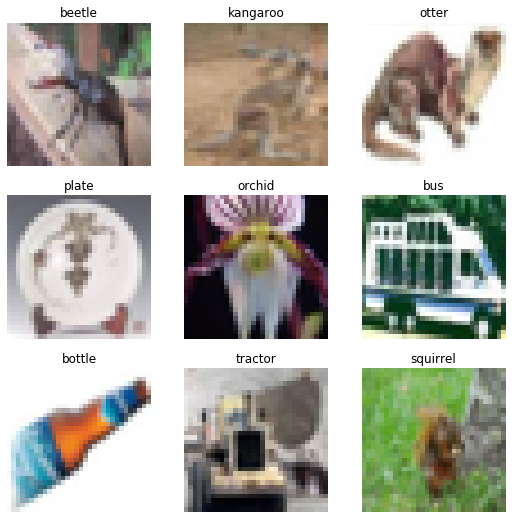

In [12]:
from fastai2.data.all import *
from fastai2.data.transforms import _grandparent_idxs
from fastai2.vision.all import *

def _ggp_idxs(items, name): return mask2idxs(Path(o).parent.parent.parent.name == name for o in items)


def GrandgrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _ggp_idxs(o, train_name),_ggp_idxs(o, valid_name)
    return _inner



mnist = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=GrandgrandparentSplitter(train_name='train', valid_name='test'),
                 get_y=parent_label)

print(untar_data(URLs.CIFAR_100).ls()[0])
dbunch = mnist.dataloaders(untar_data(URLs.CIFAR_100), bs=512, batch_tfms=[*aug_transforms(), Normalize.from_stats(*cifar_stats)])
dbunch.show_batch()

In [16]:
from fastai2.metrics import *
from fastai2.callback.all import *

test_baseline = AdversarialLearner(dbunch, model=xse_resnet34(), loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy], attack=PGDAttack(), debug=False)
test_baseline.add_cbs(TargetedLossPGD(target_relative_loss=1.10, max_eps=1e-2, eps_momentum_step=1.05, moving_average_length=5))
test_baseline.add_cbs(ReduceLROnPlateau(patience=3, factor=2))
test_baseline.add_cbs(EarlyStoppingCallback(patience=10))

test_baseline.fit(100, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.015416,3.918160,0.217400,00:20
1,3.450698,3.373423,0.328800,00:21
2,3.061142,3.294716,0.358400,00:21
3,2.767568,3.001342,0.424300,00:21
4,2.483731,3.063429,0.419800,00:20
5,2.176115,3.043174,0.446900,00:20
6,1.868870,3.166617,0.444500,00:21
7,1.434969,3.115582,0.474200,00:21
8,1.245466,3.264160,0.472900,00:21
9,1.166080,3.319612,0.475000,00:21


Epoch 6: reducing lr to 0.0015
Epoch 9: reducing lr to 0.00075


Exception ignored in: <function _releaseLock at 0x7f60db418840>
Traceback (most recent call last):
  File "/media/zediven/storage/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


IndexError: list index out of range

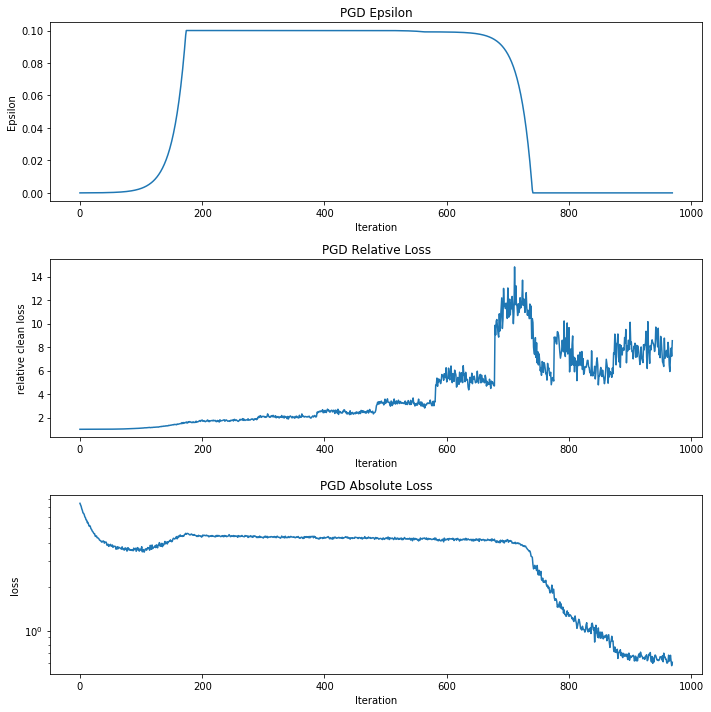

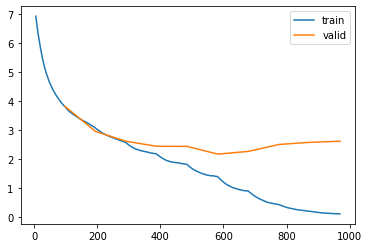

In [62]:
test_baseline.targeted_loss_pgd.plot()
test_baseline.recorder.plot_loss()

In [87]:
test_baseline_nopgd = Learner(dbunch, model=xse_resnet18(), loss_func=F.cross_entropy, metrics=[accuracy])
test_baseline_nopgd.fit_one_cycle(10, 1e-2, div_final=1e6)

epoch,train_loss,valid_loss,accuracy,time
0,0.378805,0.283014,0.908400,00:09
1,0.087877,0.171085,0.942100,00:09
2,0.051236,0.097330,0.969500,00:09
3,0.037369,0.048631,0.984800,00:09
4,0.030824,0.062898,0.981300,00:09
5,0.022082,0.034769,0.989500,00:09
6,0.011678,0.025262,0.993200,00:09
7,0.005813,0.019605,0.994800,00:09
8,0.002325,0.018079,0.995100,00:09
9,0.000937,0.019190,0.994700,00:09
